In [ ]:
# This notebook tests the making of pre-made masks for the Fizeau PSF FFT

# created 2018 July 16 by E.S., copied over from /lbti_fizeau_control/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numpy.ma as ma
import os.path
from scipy import misc, signal, ndimage
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.coordinates import Angle, SkyCoord
from astropy.nddata.utils import extract_array
from regions import PixCoord, CircleSkyRegion, CirclePixelRegion, PolygonPixelRegion
from pyregion import read_region_as_imagecoord, get_mask
import csv
import time
import pickle 
% matplotlib inline

In [2]:
from lmircam_tools import *
from lmircam_tools import overlap_psfs

In [3]:
# for starters, read in some real data and FFT the Fizeau/Airy PSFs

In [4]:
stem = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/'+
        '180507_fizeau_altair/05_centered/')

In [5]:
# if I want to read in a test frame, retrieve the pickle file and save the relevant
# array as a FITS file

'''
stemHardDrive = '/home/unasemaje/Documents/PythonPrograms/all_Python_code/2017_12_17_poppy_testing'
dict_file = open(stemHardDrive+'/pickle_files/chrom_mono_avgwavel_4060_opd_00000_tip_0000_'+
                 'tilt_0000_transl_000_PS_10.pkl', 'r')           
dict_pkld = pickle.load(dict_file)

hdu = fits.PrimaryHDU(dict_pkld['PSF_image'])
hdul = fits.HDUList([hdu])
hdul.writeto('perfect_psf.fits', overwrite=False)
'''

"\nstemHardDrive = '/home/unasemaje/Documents/PythonPrograms/all_Python_code/2017_12_17_poppy_testing'\ndict_file = open(stemHardDrive+'/pickle_files/chrom_mono_avgwavel_4060_opd_00000_tip_0000_'+\n                 'tilt_0000_transl_000_PS_10.pkl', 'r')           \ndict_pkld = pickle.load(dict_file)\n\nhdu = fits.PrimaryHDU(dict_pkld['PSF_image'])\nhdul = fits.HDUList([hdu])\nhdul.writeto('perfect_psf.fits', overwrite=False)\n"

In [6]:
# if I want to make a fake test frame involving simple gradients, generate it here
# and save array as a FITS file

# For a plane ax+by+c=z

'''
a = 116
b = 1
c = 10

xcoords_1d = np.arange(0,2048)
ycoords_1d = np.copy(xcoords_1d)

xv, yv = np.meshgrid(xcoords_1d, ycoords_1d)
zv_right = a*xv + b*yv + c

zv_left = c*xv + a*yv + b


# test to make sure I'm making the image I think I'm making
x_test = 99
y_test = 999
print(a*x_test + b*y_test + c)
print(zv[999][99])

plt.imshow(zv)
plt.colorbar()
plt.show()

hdu = fits.PrimaryHDU(zv)
hdul = fits.HDUList([hdu])
hdul.writeto('slope_test_psf.fits', overwrite=True)
'''

"\na = 116\nb = 1\nc = 10\n\nxcoords_1d = np.arange(0,2048)\nycoords_1d = np.copy(xcoords_1d)\n\nxv, yv = np.meshgrid(xcoords_1d, ycoords_1d)\nzv_right = a*xv + b*yv + c\n\nzv_left = c*xv + a*yv + b\n\n\n# test to make sure I'm making the image I think I'm making\nx_test = 99\ny_test = 999\nprint(a*x_test + b*y_test + c)\nprint(zv[999][99])\n\nplt.imshow(zv)\nplt.colorbar()\nplt.show()\n\nhdu = fits.PrimaryHDU(zv)\nhdul = fits.HDUList([hdu])\nhdul.writeto('slope_test_psf.fits', overwrite=True)\n"

In [7]:
# set units of the observation

wavel_lambda = 4.051e-6 # filter central wavel (meters); n.b. Br-alpha is 4.051 um
D = 8.25 # diameter of one downstopped primary mirror (meters)
B_c2c = 14.4 # center-to-center separation (meters)
B_e2e = 22.65 # edge-to-edge separation (meters)
plateScale = 0.0107 # (asec/pixel)
global asecInRad # define global value
asecInRad = 206264.81 # (asec/rad)

In [8]:
# locations of Airy minima/maxima (units lambda/D)

max1 = 0
min1 = 1.220
max2 = 1.635
min2 = 2.233
max3 = 2.679
min3 = 3.238
max4 = 3.699

In [9]:
def findFFTloc(baseline,imageShapeAlong1Axis,wavel_lambda,plateScale,lOverD=1.):
    '''
    Returns the FFT pixel locations equivalent to a certain pixel distance on the science image 
    '''
    
    # baseline: distance in physical space in the pupil plane (m)
    # imageShapeAlong1Axis: length of one side of the input image (needs to be square)
    # wavel_lambda: wavelength of light (m)
    # plateScale: detector plate scale (asec/pix)
    # lOverD: option if we are interested in the circular Airy rings (values 1.22, etc.); otherwise, just leave as 1
    
    line_diam_pixOnScience = lOverD*(wavel_lambda*asecInRad)/(baseline*plateScale) # distance in pixels on science detector
    line_diam_freq = np.divide(1.,line_diam_pixOnScience) # the corresponding frequency

    # find number of 'frequency pixels' multiply by units of l/D (like 1.22), and add to central x frequency pixel
    line_diam_pixOnFFT_L = 0.5*imageShapeAlong1Axis - np.divide(line_diam_freq,np.divide(1.,imageShapeAlong1Axis)) 
    line_diam_pixOnFFT_H = 0.5*imageShapeAlong1Axis + np.divide(line_diam_freq,np.divide(1.,imageShapeAlong1Axis))
    
    return line_diam_pixOnFFT_L, line_diam_pixOnFFT_H # the lower and higher values around freq of zero

In [10]:
def normalVector(sciImg):
    '''
    Fit a plane by finding the (normalized) normal vector to the best-fit plane
    
    INPUTS:
    sciImg: 2D image to fit a plane to
    
    OUTPUTS:
    normVec: the normal vector to the image data (note the normal vector is not normalIZED)
    '''
    
    # make x, y coords and flatten x, y, and z for putting into least-squares matrix equation
    X,Y = np.meshgrid(np.arange(0,np.shape(sciImg)[0]),
                  np.arange(0,np.shape(sciImg)[1]))
    Xflat_T = np.transpose(X.flatten())
    Yflat_T = np.transpose(Y.flatten())
    onesVec = np.ones(np.size(Xflat_T))
    Zflat_T = np.transpose(sciImg.flatten())

    # remove nans so we can fit planes
    Xflat_T = Xflat_T[~np.isnan(Zflat_T)]
    Yflat_T = Yflat_T[~np.isnan(Zflat_T)]
    onesVec = onesVec[~np.isnan(Zflat_T)]
    Zflat_T = Zflat_T[~np.isnan(Zflat_T)]
    
    # For a plane ax+by+c=z, the normal vector is [a,b,c]. To find this,
    # solve the matrix equation 
    
    # AC = B, where 
    # A are the x and y coords: [[x0,y0,1],[x1,y1,1],...[xN,yN,1]]
    # C are the coefficients we want: [[a],[b],[c]]
    # B is the z data: [[z0],[z1],...[zN]]
    
    # C = A+B, where A+ is the pseudoinverse of A, or A+ = ((A.T*A)^(-1))*A.T*B
    
    Amatrix = np.transpose(np.concatenate(([Xflat_T],[Yflat_T],[onesVec]), axis = 0))
    Bmatrix = Zflat_T
    
    # note that normVec = C
    normVec = np.dot(np.dot( np.linalg.pinv(np.dot(Amatrix.transpose(), Amatrix)), Amatrix.transpose()), Bmatrix)

    return normVec

In [11]:
def fftMask(sciImg,wavel_lambda,plateScale,fyi_string=''):
    '''
    Take a FFT image, generate masks to select interesting areas of the FFT, and 
    return data about those areas (amplitudes, normal vectors, etc.)
    
    INPUTS:
    sciImg: this is actually the FFT image, not the science detector image
    wavel_lambda: wavelength of the observation
    plateScale: plate scale of the detector (asec/pixel)
    fyi_string: an FYI string that could be used for plots
    
    OUTPUTS:
    dictFFTstuff: dictionary with keys corresponding to different parts of the FFT
    '''
    
    # make division lines separating different parts of the PSF
    line_M1diam_pixOnFFT = findFFTloc(D,np.shape(sciImg)[0],wavel_lambda,plateScale)
    line_center2center_pixOnFFT = findFFTloc(B_c2c,np.shape(sciImg)[0],wavel_lambda,plateScale)
    line_edge2edge_pixOnFFT = findFFTloc(B_e2e,np.shape(sciImg)[0],wavel_lambda,plateScale) 
        
        
    # define circles
    circRad = 60 # pixels in FFT space
    circle_highFreqPerfect_L = CirclePixelRegion(center=PixCoord(x=line_center2center_pixOnFFT[0], y=0.5*np.shape(sciImg)[0]), radius=circRad)
    circle_highFreqPerfect_R = CirclePixelRegion(center=PixCoord(x=line_center2center_pixOnFFT[1], y=0.5*np.shape(sciImg)[0]), radius=circRad)
    circle_lowFreqPerfect = CirclePixelRegion(center=PixCoord(x=0.5*np.shape(sciImg)[1], y=0.5*np.shape(sciImg)[0]), radius=circRad)
    
    # define central rectangular region that includes all three nodes
    rect_pix = PolygonPixelRegion(vertices=PixCoord(x=[line_edge2edge_pixOnFFT[0],line_edge2edge_pixOnFFT[1],line_edge2edge_pixOnFFT[1],line_edge2edge_pixOnFFT[0]], 
                                                       y=[line_M1diam_pixOnFFT[1],line_M1diam_pixOnFFT[1],line_M1diam_pixOnFFT[0],line_M1diam_pixOnFFT[0]]))
    
    # make the masks 
    mask_circHighFreq_L = circle_highFreqPerfect_L.to_mask()
    mask_circHighFreq_R = circle_highFreqPerfect_R.to_mask()
    mask_circLowFreq = circle_lowFreqPerfect.to_mask()
    mask_rect = rect_pix.to_mask()

    
    ## apply the masks
    
    # initialize arrays of same size as science image
    sciImg1 = np.copy(sciImg) 
    sciImg2 = np.copy(sciImg)
    sciImg3 = np.copy(sciImg)
    sciImg4 = np.copy(sciImg)
    
    # region 1: high-freq lobe, left
    sciImg1.fill(np.nan) # initialize arrays of nans
    mask_circHighFreq_L.data[mask_circHighFreq_L.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg1[mask_circHighFreq_L.bbox.slices] = mask_circHighFreq_L.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg1 = np.multiply(sciImg1,sciImg) # 'transmit' the original science image through the mask
    sciImg1 = sciImg1.filled(fill_value=np.nan) # turn all masked '--' elements to nans
    
    # region 2: high-freq lobe, right
    sciImg2.fill(np.nan) # initialize arrays of nans
    mask_circHighFreq_R.data[mask_circHighFreq_R.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg2[mask_circHighFreq_R.bbox.slices] = mask_circHighFreq_R.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg2 = np.multiply(sciImg2,sciImg) # 'transmit' the original science image through the mask
    sciImg2 = sciImg2.filled(fill_value=np.nan) # turn all masked '--' elements to nans
    
    # region 3: low-freq lobe
    sciImg3.fill(np.nan) # initialize arrays of nans
    mask_circLowFreq.data[mask_circLowFreq.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg3[mask_circLowFreq.bbox.slices] = mask_circLowFreq.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg3 = np.multiply(sciImg3,sciImg) # 'transmit' the original science image through the mask
    sciImg3 = sciImg3.filled(fill_value=np.nan) # turn all masked '--' elements to nans
    
    # region 4: rectangular region containing parts of all lobes
    sciImg4.fill(np.nan) # initialize arrays of nans
    mask_rect.data[mask_rect.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg4[mask_rect.bbox.slices] = mask_rect.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg4 = np.multiply(sciImg4,sciImg) # 'transmit' the original science image through the mask
    sciImg4 = sciImg4.filled(fill_value=np.nan) # turn all masked '--' elements to nans
    
    ## ## TEST
    #sciImg3 = np.multiply(sciImg3,zv_right[0:1200,0:1200])
    
    # return medians of regions under masks
    med_highFreqPerfect_L = np.nanmedian(sciImg1)
    med_highFreqPerfect_R = np.nanmedian(sciImg2)
    med_lowFreqPerfect = np.nanmedian(sciImg3)
    med_rect = np.nanmedian(sciImg4)
    
    # return normal vectors corresponding to [x,y,z] to surfaces (x- and y- components are of interest)
    normVec_highFreqPerfect_L = normalVector(sciImg1)
    normVec_highFreqPerfect_R = normalVector(sciImg2)
    normVec_lowFreqPerfect = normalVector(sciImg3)
    normVec_rect = normalVector(sciImg4)
    
    # return stdev in each region
    std_highFreqPerfect_L = np.nanstd(sciImg1)
    std_highFreqPerfect_R = np.nanstd(sciImg2)
    std_lowFreqPerfect = np.nanstd(sciImg3)
    std_rect = np.nanstd(sciImg4)
        
    # generate images showing footprints of regions of interest
    # (comment this bit in/out as desired)
    
    ''' 
    %matplotlib auto
    plt.imshow(sciImg1, origin='lower')
    plt.colorbar()
    plt.show()
    
    plt.imshow(sciImg2, origin='lower')
    plt.title('Region 2, frame '+fyi_string)
    plt.colorbar()
    plt.show()
    
    plt.imshow(sciImg3, origin='lower')
    plt.title('Region 3, frame '+fyi_string)
    plt.colorbar()
    plt.show()
    
    plt.imshow(sciImg4, origin='lower')
    plt.title('Region 4, frame '+fyi_string)
    plt.colorbar()
    plt.show()
    '''
    
    # generate image with lines denoting regions
    # (comment this in/out as desired)
    '''
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    cax = ax.imshow(sciImg, origin="lower")
    ax.axhline(line_M1diam_pixOnFFT[0])
    ax.axhline(line_M1diam_pixOnFFT[1])
    ax.axvline(line_M1diam_pixOnFFT[0])
    ax.axvline(line_M1diam_pixOnFFT[1])
    ax.axvline(line_center2center_pixOnFFT[0])
    ax.axvline(line_center2center_pixOnFFT[1])
    ax.axvline(line_edge2edge_pixOnFFT[0]) 
    ax.axvline(line_edge2edge_pixOnFFT[1]) 
    ax.add_patch(circle_highFreqPerfect_L.as_patch(facecolor='none', edgecolor='blue')) 
    ax.add_patch(circle_highFreqPerfect_R.as_patch(facecolor='none', edgecolor='blue')) 
    ax.add_patch(circle_lowFreqPerfect.as_patch(facecolor='none', edgecolor='blue')) 
    ax.add_patch(rect_pix.as_patch(facecolor='none', edgecolor='red')) 
    cbar = fig.colorbar(cax)
    plt.savefig("junk.pdf")
    '''
    
    # initialize dictionary to contain FFT data
    # N.b. all the info in this dictionary is EITHER for
    # the FFT amplitude OR the FFT phase, depending on what
    # the 'sciImg' is
    dictFFTstuff = {}
    
    # median of high-freq lobe on left side, within circular region centered around 
    # where a perfect high-freq lobe would be
    dictFFTstuff["med_highFreqPerfect_L"] = med_highFreqPerfect_L
    
    # median of right-side high-freq lobe
    dictFFTstuff["med_highFreqPerfect_R"] = med_highFreqPerfect_R
    
    # median of low-frequency lobe
    dictFFTstuff["med_lowFreqPerfect"] = med_lowFreqPerfect
    
    # median of rectangle that is drawn to contain both high- and low-freq lobes
    dictFFTstuff["med_rect"] = med_rect
    
    # stdev of the same regions
    dictFFTstuff["std_highFreqPerfect_L"] = std_highFreqPerfect_L
    
    # median of right-side high-freq lobe
    dictFFTstuff["std_highFreqPerfect_R"] = std_highFreqPerfect_R
    
    # median of low-frequency lobe
    dictFFTstuff["std_lowFreqPerfect"] = std_lowFreqPerfect
    
    # median of rectangle that is drawn to contain both high- and low-freq lobes
    dictFFTstuff["std_rect"] = std_rect
    
    # normal vectors to the high- and low- frequency 
    # note vectors are [a,b,c] corresponding to the eqn Z = a*X + b*Y + c
    dictFFTstuff["normVec_highFreqPerfect_L"] = normVec_highFreqPerfect_L
    dictFFTstuff["normVec_highFreqPerfect_R"] = normVec_highFreqPerfect_R
    dictFFTstuff["normVec_lowFreqPerfect"] = normVec_lowFreqPerfect
    dictFFTstuff["normVec_rect"] = normVec_rect
        
    return dictFFTstuff

In [12]:
# for loop over science images to take FFT and analyze it

ampArray = []
framenumArray = []

counter_num = 0

#datafilename = "test.csv"

startFrame = 4000 # 4000
stopFrame = 11335 # 11335 # (inclusive)

for f in range(startFrame,stopFrame+1):  # full Altair dataset: 4249,11497

    start = time.time() # start timer
    
    filename_str = stem+'lm_180507_'+str("{:0>6d}".format(f))+'_nPCA164.fits'
    
    if os.path.isfile(filename_str): # if FITS file exists in the first place
            
        print('Working on frame '+str("{:0>6d}".format(f))+' ...')
        
        image, header = fits.getdata(filename_str,0,header=True) 

        '''
        # test: a perfect PSF
        image, header = fits.getdata('perfect_psf.fits',0,header=True) 
    
        # locate PSF (this is only to nearest pixel)
        psf_loc = overlap_psfs.find_airy_psf(image)
        '''
        
        # size of cookie cut-out (measured center-to-edge)
        cookie_size = 50 # maximum control radius as of 2018 July corresponds to 130.0 pixels
    
        # take FFT, where arrays are already cookie cut-outs
        cookie_cut = np.copy(image)
        amp, arg = fft_img(cookie_cut).fft(padding=int(5*cookie_size), mask_thresh=1e5)

        # test: image with a perfect slope
        '''
        testing, header = fits.getdata('slope_test_psf.fits',0,header=True)
        cookie_cut_testing = testing[psf_loc[0]-cookie_size:psf_loc[0]+
                                   cookie_size,psf_loc[1]-cookie_size:psf_loc[1]+cookie_size]
        #sciImg = ma.asarray(sciImg)
        amp[np.isfinite(amp)] = -1 #cookie_cut_testing[np.isfinite(amp)] 
        '''
        
        # sanity check (and to avoid getting for loop stuck)
        if (np.shape(amp)[0]!=np.shape(amp)[1]): # if the FFT doesn't make sense (i.e., if PSF was not found)
            print('PSF does not make sense ... aborting this one ...')
            continue
            
            
        # analyze FFTs
        fftInfo_amp = fftMask(amp,wavel_lambda,plateScale,
                              fyi_string=str("{:0>6d}".format(f))+' FFT amp')
        fftInfo_arg = fftMask(arg,wavel_lambda,plateScale,
                              fyi_string=str("{:0>6d}".format(f))+' FFT phase')
        
        
        # save a fyi PNG file
        '''
        fig, (ax0, ax1, ax2) = plt.subplots(ncols=3,figsize=(20,5))
        im0 = ax0.imshow(cookie_cut, origin="lower") 
        ax0.plot([int(0.5*np.shape(cookie_cut)[0]),int(0.5*np.shape(cookie_cut)[0])],
                 [int(0.5*np.shape(cookie_cut)[0]),int(0.5*np.shape(cookie_cut)[0])],
                 marker="+", color="r") # put red cross at center
        ax0.set_xlim([0,np.shape(cookie_cut)[0]])
        ax0.set_ylim([0,np.shape(cookie_cut)[0]])
        im1 = ax1.imshow(amp, origin="lower") 
        im2 = ax2.imshow(arg, origin="lower") 
        fig.colorbar(im0, ax=ax0)
        fig.colorbar(im1, ax=ax1)
        fig.colorbar(im2, ax=ax2)
        ax0.set_xlabel('Physical PSF (color = counts)')
        ax1.set_xlabel('FFT Ampl (color = relative)')
        ax2.set_xlabel('FFT Phase (color = degrees)')
        if (header['PCCLOSED']==1): # if Phasecam loop was closed
            pc_string = 'PC **CLOSED**'
        else:
            pc_string = 'PC OPEN'
        plt.suptitle(str("{:0>6d}".format(f)) + ', ' + pc_string)
        plt.savefig(stem+"png_thumbnails/test_data_"+str("{:0>6d}".format(f))+".png", dpi=300, overwrite=True)
        plt.close()
        plt.clf()
        '''
        # write data to text file
        # CAUTION IF EDITING THE BELOW; NEED TO
        # MAKE SURE COLUMN HEADERS AND DATA AGREE
        
        # this snippet can be commented out if you 
        # dont want to erase a pre-existing csv file
        if (f==startFrame): # write column headers in file
            colheaders = ["framenum",
                          "ampl_med_highFreqPerfect_L",
                          "ampl_med_highFreqPerfect_R",
                          "ampl_med_lowFreqPerfect",
                          "ampl_med_rect",
                          "ampl_std_highFreqPerfect_L",
                          "ampl_std_highFreqPerfect_R",
                          "ampl_std_lowFreqPerfect",
                          "ampl_std_rect",
                          "ampl_normVec_highFreqPerfect_L_x",
                          "ampl_normVec_highFreqPerfect_L_y",
                          "ampl_normVec_highFreqPerfect_R_x",
                          "ampl_normVec_highFreqPerfect_R_y",
                          "ampl_normVec_lowFreqPerfect_x",
                          "ampl_normVec_lowFreqPerfect_y",
                          "ampl_normVec_rect_x",
                          "ampl_normVec_rect_y",
                          "phase_med_highFreqPerfect_L",
                          "phase_med_highFreqPerfect_R",
                          "phase_med_lowFreqPerfect",
                          "phase_med_rect",
                          "phase_std_highFreqPerfect_L",
                          "phase_std_highFreqPerfect_R",
                          "phase_std_lowFreqPerfect",
                          "phase_std_rect",
                          "phase_normVec_highFreqPerfect_L_x",
                          "phase_normVec_highFreqPerfect_L_y",
                          "phase_normVec_highFreqPerfect_R_x",
                          "phase_normVec_highFreqPerfect_R_y",
                          "phase_normVec_lowFreqPerfect_x",
                          "phase_normVec_lowFreqPerfect_y",
                          "phase_normVec_rect_x",
                          "phase_normVec_rect_y"]
            with open(r'test.csv', 'w') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(colheaders)
        
        # append to file:
        # [0]: frame number
        # [1-16]: FFT amplitude data
        # [17-32]: FFT phase data
        fields=[str("{:0>6d}".format(f)),
                fftInfo_amp["med_highFreqPerfect_L"],
                fftInfo_amp["med_highFreqPerfect_R"],
                fftInfo_amp["med_lowFreqPerfect"],
                fftInfo_amp["med_rect"],
                fftInfo_amp["std_highFreqPerfect_L"],
                fftInfo_amp["std_highFreqPerfect_R"],
                fftInfo_amp["std_lowFreqPerfect"],
                fftInfo_amp["std_rect"],
                fftInfo_amp["normVec_highFreqPerfect_L"][0],
                fftInfo_amp["normVec_highFreqPerfect_L"][1],
                fftInfo_amp["normVec_highFreqPerfect_R"][0],
                fftInfo_amp["normVec_highFreqPerfect_R"][1],
                fftInfo_amp["normVec_lowFreqPerfect"][0],
                fftInfo_amp["normVec_lowFreqPerfect"][1],
                fftInfo_amp["normVec_rect"][0],
                fftInfo_amp["normVec_rect"][1],
                fftInfo_arg["med_highFreqPerfect_L"],
                fftInfo_arg["med_highFreqPerfect_R"],
                fftInfo_arg["med_lowFreqPerfect"],
                fftInfo_arg["med_rect"],
                fftInfo_arg["std_highFreqPerfect_L"],
                fftInfo_arg["std_highFreqPerfect_R"],
                fftInfo_arg["std_lowFreqPerfect"],
                fftInfo_arg["std_rect"],
                fftInfo_arg["normVec_highFreqPerfect_L"][0],
                fftInfo_arg["normVec_highFreqPerfect_L"][1],
                fftInfo_arg["normVec_highFreqPerfect_R"][0],
                fftInfo_arg["normVec_highFreqPerfect_R"][1],
                fftInfo_arg["normVec_lowFreqPerfect"][0],
                fftInfo_arg["normVec_lowFreqPerfect"][1],
                fftInfo_arg["normVec_rect"][0],
                fftInfo_arg["normVec_rect"][1]]
        with open(r'test.csv', 'a') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(fields)
            
    else: # if file does not exist
        print('Frame '+str("{:0>6d}".format(f))+' not found.')
            
    end = time.time()
    print(end - start)
    print('-----')

Frame 004000 not found.
0.000788927078247
-----
Frame 004001 not found.
0.000381946563721
-----
Frame 004002 not found.
0.000366926193237
-----
Frame 004003 not found.
0.000314950942993
-----
Frame 004004 not found.
0.000331878662109
-----
Frame 004005 not found.
0.000347137451172
-----
Frame 004006 not found.
0.000381946563721
-----
Frame 004007 not found.
0.000311851501465
-----
Frame 004008 not found.
0.0002760887146
-----
Frame 004009 not found.
0.00026798248291
-----
Frame 004010 not found.
0.000270128250122
-----
Frame 004011 not found.
0.000265836715698
-----
Frame 004012 not found.
0.000263929367065
-----
Frame 004013 not found.
0.000340938568115
-----
Frame 004014 not found.
0.000266075134277
-----
Frame 004015 not found.
0.000274896621704
-----
Frame 004016 not found.
0.000265121459961
-----
Frame 004017 not found.
0.000264883041382
-----
Frame 004018 not found.
0.000263929367065
-----
Frame 004019 not found.
0.000327110290527
-----
Frame 004020 not found.
0.000262975692749
-

0.459293842316
-----
Working on frame 004250 ...
0.353628873825
-----
Working on frame 004251 ...
0.349789142609
-----
Working on frame 004252 ...
0.347171068192
-----
Working on frame 004253 ...
0.350621938705
-----
Working on frame 004254 ...
0.348990917206
-----
Working on frame 004255 ...
0.351984977722
-----
Working on frame 004256 ...
0.351022005081
-----
Working on frame 004257 ...
0.349917888641
-----
Working on frame 004258 ...
0.35001707077
-----
Working on frame 004259 ...
0.350739002228
-----
Working on frame 004260 ...
0.348765850067
-----
Working on frame 004261 ...
0.349388837814
-----
Working on frame 004262 ...
0.347280025482
-----
Working on frame 004263 ...
0.349804878235
-----
Working on frame 004264 ...
0.349178791046
-----
Working on frame 004265 ...
0.352483034134
-----
Working on frame 004266 ...
0.349353075027
-----
Working on frame 004267 ...
0.351253986359
-----
Working on frame 004268 ...
0.348570108414
-----
Working on frame 004269 ...
0.350075006485
-----


0.350865125656
-----
Working on frame 004418 ...
0.351317167282
-----
Working on frame 004419 ...
0.35258102417
-----
Working on frame 004420 ...
0.351717948914
-----
Working on frame 004421 ...
0.352733135223
-----
Working on frame 004422 ...
0.351217985153
-----
Working on frame 004423 ...
0.353911161423
-----
Working on frame 004424 ...
0.353753805161
-----
Working on frame 004425 ...
0.349453926086
-----
Working on frame 004426 ...
0.34968495369
-----
Working on frame 004427 ...
0.351749181747
-----
Working on frame 004428 ...
0.349438905716
-----
Working on frame 004429 ...
0.348823070526
-----
Working on frame 004430 ...
0.348921060562
-----
Working on frame 004431 ...
0.351871967316
-----
Working on frame 004432 ...
0.349025011063
-----
Working on frame 004433 ...
0.348367929459
-----
Working on frame 004434 ...
0.351613998413
-----
Working on frame 004435 ...
0.353574037552
-----
Working on frame 004436 ...
0.3521900177
-----
Working on frame 004437 ...
0.352426052094
-----
Wor

0.361588001251
-----
Working on frame 004586 ...
0.359110116959
-----
Working on frame 004587 ...
0.358878850937
-----
Working on frame 004588 ...
0.358409881592
-----
Working on frame 004589 ...
0.366317033768
-----
Working on frame 004590 ...
0.358216047287
-----
Working on frame 004591 ...
0.357439994812
-----
Working on frame 004592 ...
0.361290931702
-----
Working on frame 004593 ...
0.360543012619
-----
Working on frame 004594 ...
0.358655929565
-----
Working on frame 004595 ...
0.356058835983
-----
Working on frame 004596 ...
0.359137058258
-----
Working on frame 004597 ...
0.360629081726
-----
Working on frame 004598 ...
0.358985900879
-----
Working on frame 004599 ...
0.359750032425
-----
Working on frame 004600 ...
0.359141111374
-----
Working on frame 004601 ...
0.359125137329
-----
Working on frame 004602 ...
0.356813907623
-----
Working on frame 004603 ...
0.362541913986
-----
Working on frame 004604 ...
0.356686115265
-----
Working on frame 004605 ...
0.359482049942
-----

0.360821008682
-----
Working on frame 004754 ...
0.355406999588
-----
Working on frame 004755 ...
0.35991692543
-----
Working on frame 004756 ...
0.360965013504
-----
Working on frame 004757 ...
0.360610961914
-----
Working on frame 004758 ...
0.356605052948
-----
Working on frame 004759 ...
0.356339931488
-----
Working on frame 004760 ...
0.35676407814
-----
Working on frame 004761 ...
0.350092887878
-----
Working on frame 004762 ...
0.352833986282
-----
Working on frame 004763 ...
0.355219125748
-----
Working on frame 004764 ...
0.349860906601
-----
Working on frame 004765 ...
0.355468988419
-----
Working on frame 004766 ...
0.354528903961
-----
Working on frame 004767 ...
0.353049993515
-----
Working on frame 004768 ...
0.353776931763
-----
Working on frame 004769 ...
0.356075048447
-----
Working on frame 004770 ...
0.351490974426
-----
Working on frame 004771 ...
0.354774951935
-----
Working on frame 004772 ...
0.352754831314
-----
Working on frame 004773 ...
0.353793144226
-----
W

0.359364032745
-----
Working on frame 004922 ...
0.358455896378
-----
Working on frame 004923 ...
0.360702037811
-----
Working on frame 004924 ...
0.358678102493
-----
Working on frame 004925 ...
0.359579801559
-----
Working on frame 004926 ...
0.354634046555
-----
Working on frame 004927 ...
0.359016180038
-----
Working on frame 004928 ...
0.359280109406
-----
Working on frame 004929 ...
0.360894918442
-----
Working on frame 004930 ...
0.360402107239
-----
Working on frame 004931 ...
0.358303070068
-----
Working on frame 004932 ...
0.357985019684
-----
Working on frame 004933 ...
0.360357999802
-----
Working on frame 004934 ...
0.353090047836
-----
Working on frame 004935 ...
0.356154203415
-----
Working on frame 004936 ...
0.357688903809
-----
Working on frame 004937 ...
0.361581087112
-----
Working on frame 004938 ...
0.356971025467
-----
Working on frame 004939 ...
0.354981899261
-----
Working on frame 004940 ...
0.349844932556
-----
Working on frame 004941 ...
0.360906124115
-----

0.349688053131
-----
Working on frame 005090 ...
0.355782985687
-----
Working on frame 005091 ...
0.352214097977
-----
Working on frame 005092 ...
0.349408864975
-----
Working on frame 005093 ...
0.347548961639
-----
Working on frame 005094 ...
0.355310916901
-----
Working on frame 005095 ...
0.348304033279
-----
Working on frame 005096 ...
0.348896026611
-----
Working on frame 005097 ...
0.350624084473
-----
Working on frame 005098 ...
0.348922014236
-----
Working on frame 005099 ...
0.348904132843
-----
Working on frame 005100 ...
0.348936080933
-----
Working on frame 005101 ...
0.349611997604
-----
Working on frame 005102 ...
0.352446079254
-----
Working on frame 005103 ...
0.350336790085
-----
Working on frame 005104 ...
0.354762077332
-----
Working on frame 005105 ...
0.356537818909
-----
Working on frame 005106 ...
0.347516059875
-----
Working on frame 005107 ...
0.349873065948
-----
Working on frame 005108 ...
0.353549003601
-----
Working on frame 005109 ...
0.353276014328
-----

0.348721981049
-----
Working on frame 005258 ...
0.354486942291
-----
Working on frame 005259 ...
0.348953962326
-----
Working on frame 005260 ...
0.352370023727
-----
Working on frame 005261 ...
0.351083993912
-----
Working on frame 005262 ...
0.351586818695
-----
Working on frame 005263 ...
0.348519086838
-----
Working on frame 005264 ...
0.35285782814
-----
Working on frame 005265 ...
0.348122119904
-----
Working on frame 005266 ...
0.349819898605
-----
Working on frame 005267 ...
0.350337982178
-----
Working on frame 005268 ...
0.355428934097
-----
Working on frame 005269 ...
0.352671146393
-----
Working on frame 005270 ...
0.349272966385
-----
Working on frame 005271 ...
0.349166154861
-----
Working on frame 005272 ...
0.352751016617
-----
Working on frame 005273 ...
0.349000930786
-----
Working on frame 005274 ...
0.349666118622
-----
Working on frame 005275 ...
0.349735021591
-----
Working on frame 005276 ...
0.351418972015
-----
Working on frame 005277 ...
0.346260786057
-----


0.350219011307
-----
Working on frame 005426 ...
0.350476026535
-----
Working on frame 005427 ...
0.350810050964
-----
Working on frame 005428 ...
0.349009037018
-----
Working on frame 005429 ...
0.350776910782
-----
Working on frame 005430 ...
0.352046012878
-----
Working on frame 005431 ...
0.349027872086
-----
Working on frame 005432 ...
0.352149963379
-----
Working on frame 005433 ...
0.352746963501
-----
Working on frame 005434 ...
0.350282907486
-----
Working on frame 005435 ...
0.351546049118
-----
Working on frame 005436 ...
0.352880954742
-----
Working on frame 005437 ...
0.352936029434
-----
Working on frame 005438 ...
0.348295927048
-----
Working on frame 005439 ...
0.353905200958
-----
Working on frame 005440 ...
0.351454019547
-----
Working on frame 005441 ...
0.350399017334
-----
Working on frame 005442 ...
0.351114988327
-----
Working on frame 005443 ...
0.349462985992
-----
Working on frame 005444 ...
0.355200052261
-----
Working on frame 005445 ...
0.350610971451
-----

0.349516868591
-----
Working on frame 005594 ...
0.351100921631
-----
Working on frame 005595 ...
0.349219083786
-----
Working on frame 005596 ...
0.34753704071
-----
Working on frame 005597 ...
0.34926199913
-----
Working on frame 005598 ...
0.348258972168
-----
Working on frame 005599 ...
0.353144168854
-----
Working on frame 005600 ...
0.35181593895
-----
Working on frame 005601 ...
0.353303909302
-----
Working on frame 005602 ...
0.347820043564
-----
Working on frame 005603 ...
0.351978063583
-----
Working on frame 005604 ...
0.353435993195
-----
Working on frame 005605 ...
0.354044914246
-----
Working on frame 005606 ...
0.350097894669
-----
Working on frame 005607 ...
0.354720115662
-----
Working on frame 005608 ...
0.354156970978
-----
Working on frame 005609 ...
0.350522994995
-----
Working on frame 005610 ...
0.348347902298
-----
Working on frame 005611 ...
0.360569000244
-----
Working on frame 005612 ...
0.352177143097
-----
Frame 005613 not found.
0.000504970550537
-----
Fra

/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.453592061996
-----
Working on frame 005616 ...
0.339164018631
-----
Working on frame 005617 ...
0.336755037308
-----
Working on frame 005618 ...
0.337724208832
-----
Working on frame 005619 ...
0.342008829117
-----
Frame 005620 not found.
0.000489950180054
-----
Frame 005621 not found.
0.000448226928711
-----
Frame 005622 not found.
0.00042200088501
-----
Working on frame 005623 ...
0.33616900444
-----
Working on frame 005624 ...
0.335988044739
-----
Working on frame 005625 ...
0.334915876389
-----
Working on frame 005626 ...
0.339475870132
-----
Frame 005627 not found.
0.000520944595337
-----
Working on frame 005628 ...
0.334782838821
-----
Frame 005629 not found.
0.000519037246704
-----
Working on frame 005630 ...
0.340867042542
-----
Frame 005631 not found.
0.000513076782227
-----
Frame 005632 not found.
0.000439167022705
-----
Working on frame 005633 ...
0.33384013176
-----
Working on frame 005634 ...
0.337584972382
-----
Working on frame 005635 ...
0.336071014404
-----
Working o

0.349323034286
-----
Working on frame 005784 ...
0.352538108826
-----
Working on frame 005785 ...
0.352928161621
-----
Working on frame 005786 ...
0.353270053864
-----
Working on frame 005787 ...
0.351308107376
-----
Working on frame 005788 ...
0.359753131866
-----
Working on frame 005789 ...
0.352941036224
-----
Working on frame 005790 ...
0.355315923691
-----
Working on frame 005791 ...
0.354200124741
-----
Working on frame 005792 ...
0.358861923218
-----
Working on frame 005793 ...
0.350389957428
-----
Working on frame 005794 ...
0.346326112747
-----
Working on frame 005795 ...
0.353744029999
-----
Working on frame 005796 ...
0.357527971268
-----
Working on frame 005797 ...
0.351556062698
-----
Working on frame 005798 ...
0.358931064606
-----
Working on frame 005799 ...
0.352046012878
-----
Working on frame 005800 ...
0.351077079773
-----
Working on frame 005801 ...
0.352510213852
-----
Working on frame 005802 ...
0.353763103485
-----
Working on frame 005803 ...
0.352824926376
-----

0.359528779984
-----
Working on frame 005952 ...
0.365156888962
-----
Working on frame 005953 ...
0.358686923981
-----
Working on frame 005954 ...
0.362514972687
-----
Working on frame 005955 ...
0.359028100967
-----
Working on frame 005956 ...
0.358532905579
-----
Working on frame 005957 ...
0.360430955887
-----
Working on frame 005958 ...
0.361642122269
-----
Working on frame 005959 ...
0.356513977051
-----
Working on frame 005960 ...
0.360194921494
-----
Working on frame 005961 ...
0.361713886261
-----
Working on frame 005962 ...
0.363909959793
-----
Working on frame 005963 ...
0.357180833817
-----
Working on frame 005964 ...
0.36283493042
-----
Working on frame 005965 ...
0.361559152603
-----
Working on frame 005966 ...
0.362323999405
-----
Working on frame 005967 ...
0.358639001846
-----
Working on frame 005968 ...
0.364844083786
-----
Working on frame 005969 ...
0.360394001007
-----
Working on frame 005970 ...
0.362663030624
-----
Working on frame 005971 ...
0.358325004578
-----


0.35929107666
-----
Working on frame 006120 ...
0.363013029099
-----
Working on frame 006121 ...
0.358501911163
-----
Working on frame 006122 ...
0.358565092087
-----
Working on frame 006123 ...
0.35364985466
-----
Working on frame 006124 ...
0.362758874893
-----
Working on frame 006125 ...
0.358411073685
-----
Working on frame 006126 ...
0.363102912903
-----
Working on frame 006127 ...
0.352311134338
-----
Working on frame 006128 ...
0.360181093216
-----
Working on frame 006129 ...
0.354634046555
-----
Working on frame 006130 ...
0.360816955566
-----
Working on frame 006131 ...
0.361796140671
-----
Working on frame 006132 ...
0.364254951477
-----
Working on frame 006133 ...
0.358110904694
-----
Working on frame 006134 ...
0.366020917892
-----
Working on frame 006135 ...
0.35836815834
-----
Working on frame 006136 ...
0.358150005341
-----
Working on frame 006137 ...
0.35810303688
-----
Working on frame 006138 ...
0.361222028732
-----
Working on frame 006139 ...
0.357343912125
-----
Wor

0.356974840164
-----
Working on frame 006288 ...
0.362874984741
-----
Working on frame 006289 ...
0.356757879257
-----
Working on frame 006290 ...
0.35555100441
-----
Working on frame 006291 ...
0.358529090881
-----
Working on frame 006292 ...
0.356070995331
-----
Working on frame 006293 ...
0.360690832138
-----
Working on frame 006294 ...
0.358497142792
-----
Working on frame 006295 ...
0.361127853394
-----
Working on frame 006296 ...
0.360241889954
-----
Working on frame 006297 ...
0.357658147812
-----
Working on frame 006298 ...
0.360905885696
-----
Working on frame 006299 ...
0.356800079346
-----
Working on frame 006300 ...
0.360723018646
-----
Working on frame 006301 ...
0.360353946686
-----
Working on frame 006302 ...
0.341432094574
-----
Working on frame 006303 ...
0.337956905365
-----
Working on frame 006304 ...
0.344259977341
-----
Working on frame 006305 ...
0.338794231415
-----
Working on frame 006306 ...
0.343564987183
-----
Working on frame 006307 ...
0.335373163223
-----


0.343699932098
-----
Working on frame 006456 ...
0.341924905777
-----
Working on frame 006457 ...
0.344751119614
-----
Working on frame 006458 ...
0.353021144867
-----
Working on frame 006459 ...
0.337973117828
-----
Working on frame 006460 ...
0.341380834579
-----
Working on frame 006461 ...
0.341155052185
-----
Working on frame 006462 ...
0.342436790466
-----
Working on frame 006463 ...
0.344676017761
-----
Working on frame 006464 ...
0.341465950012
-----
Working on frame 006465 ...
0.342033147812
-----
Working on frame 006466 ...
0.345577001572
-----
Working on frame 006467 ...
0.342251777649
-----
Working on frame 006468 ...
0.342529058456
-----
Working on frame 006469 ...
0.345818996429
-----
Working on frame 006470 ...
0.343440055847
-----
Working on frame 006471 ...
0.347650051117
-----
Working on frame 006472 ...
0.346210956573
-----
Working on frame 006473 ...
0.342344999313
-----
Working on frame 006474 ...
0.343374967575
-----
Working on frame 006475 ...
0.342754840851
-----

0.348123073578
-----
Working on frame 006624 ...
0.35365486145
-----
Working on frame 006625 ...
0.35125207901
-----
Working on frame 006626 ...
0.355318069458
-----
Working on frame 006627 ...
0.348448991776
-----
Working on frame 006628 ...
0.336151123047
-----
Working on frame 006629 ...
0.345540046692
-----
Working on frame 006630 ...
0.349319934845
-----
Working on frame 006631 ...
0.339699029922
-----
Working on frame 006632 ...
0.349229097366
-----
Working on frame 006633 ...
0.33758687973
-----
Working on frame 006634 ...
0.350323915482
-----
Working on frame 006635 ...
0.348623037338
-----
Working on frame 006636 ...
0.34849691391
-----
Working on frame 006637 ...
0.348882913589
-----
Working on frame 006638 ...
0.350228071213
-----
Working on frame 006639 ...
0.351216077805
-----
Working on frame 006640 ...
0.352799892426
-----
Working on frame 006641 ...
0.349065065384
-----
Working on frame 006642 ...
0.350341081619
-----
Working on frame 006643 ...
0.348969936371
-----
Wor

0.349542140961
-----
Working on frame 006792 ...
0.348368883133
-----
Working on frame 006793 ...
0.350350856781
-----
Working on frame 006794 ...
0.35179901123
-----
Working on frame 006795 ...
0.348973989487
-----
Working on frame 006796 ...
0.352814912796
-----
Working on frame 006797 ...
0.35250711441
-----
Working on frame 006798 ...
0.348550081253
-----
Working on frame 006799 ...
0.351490020752
-----
Working on frame 006800 ...
0.354494094849
-----
Working on frame 006801 ...
0.354423999786
-----
Working on frame 006802 ...
0.348857879639
-----
Working on frame 006803 ...
0.347972154617
-----
Working on frame 006804 ...
0.350571870804
-----
Working on frame 006805 ...
0.34229016304
-----
Working on frame 006806 ...
0.342227935791
-----
Working on frame 006807 ...
0.347991943359
-----
Working on frame 006808 ...
0.352900028229
-----
Working on frame 006809 ...
0.342118024826
-----
Working on frame 006810 ...
0.354145050049
-----
Working on frame 006811 ...
0.348072052002
-----
Wo

0.353429079056
-----
Working on frame 006960 ...
0.354229927063
-----
Working on frame 006961 ...
0.352996826172
-----
Working on frame 006962 ...
0.358386039734
-----
Working on frame 006963 ...
0.353892087936
-----
Working on frame 006964 ...
0.356153964996
-----
Working on frame 006965 ...
0.35383105278
-----
Working on frame 006966 ...
0.357616901398
-----
Working on frame 006967 ...
0.352692842484
-----
Working on frame 006968 ...
0.355072975159
-----
Working on frame 006969 ...
0.350528001785
-----
Working on frame 006970 ...
0.335556030273
-----
Working on frame 006971 ...
0.346354007721
-----
Working on frame 006972 ...
0.354386091232
-----
Working on frame 006973 ...
0.355406045914
-----
Working on frame 006974 ...
0.354918956757
-----
Working on frame 006975 ...
0.351821899414
-----
Working on frame 006976 ...
0.356342077255
-----
Working on frame 006977 ...
0.357837915421
-----
Working on frame 006978 ...
0.348719120026
-----
Working on frame 006979 ...
0.34836101532
-----
W

0.343914031982
-----
Working on frame 007128 ...
0.350244998932
-----
Working on frame 007129 ...
0.346691846848
-----
Working on frame 007130 ...
0.342782020569
-----
Working on frame 007131 ...
0.353348016739
-----
Working on frame 007132 ...
0.349664926529
-----
Working on frame 007133 ...
0.345387935638
-----
Working on frame 007134 ...
0.344504117966
-----
Working on frame 007135 ...
0.352776050568
-----
Working on frame 007136 ...
0.345051050186
-----
Working on frame 007137 ...
0.348417043686
-----
Working on frame 007138 ...
0.349250078201
-----
Working on frame 007139 ...
0.343364953995
-----
Working on frame 007140 ...
0.34832906723
-----
Working on frame 007141 ...
0.354285955429
-----
Working on frame 007142 ...
0.348637104034
-----
Working on frame 007143 ...
0.353947162628
-----
Working on frame 007144 ...
0.348273992538
-----
Working on frame 007145 ...
0.352481842041
-----
Working on frame 007146 ...
0.346796989441
-----
Working on frame 007147 ...
0.343863010406
-----


0.345407009125
-----
Working on frame 007296 ...
0.344132900238
-----
Working on frame 007297 ...
0.347815036774
-----
Working on frame 007298 ...
0.348623037338
-----
Working on frame 007299 ...
0.344450950623
-----
Working on frame 007300 ...
0.343333005905
-----
Working on frame 007301 ...
0.353533029556
-----
Working on frame 007302 ...
0.344335079193
-----
Working on frame 007303 ...
0.348758935928
-----
Working on frame 007304 ...
0.341954946518
-----
Working on frame 007305 ...
0.346018075943
-----
Working on frame 007306 ...
0.346705913544
-----
Working on frame 007307 ...
0.346786975861
-----
Working on frame 007308 ...
0.345921993256
-----
Working on frame 007309 ...
0.347867012024
-----
Working on frame 007310 ...
0.348591089249
-----
Working on frame 007311 ...
0.355533838272
-----
Working on frame 007312 ...
0.342158079147
-----
Working on frame 007313 ...
0.342048168182
-----
Working on frame 007314 ...
0.344320058823
-----
Working on frame 007315 ...
0.348566055298
-----

0.350003957748
-----
Working on frame 007464 ...
0.352205991745
-----
Working on frame 007465 ...
0.357136964798
-----
Working on frame 007466 ...
0.350780963898
-----
Working on frame 007467 ...
0.350425004959
-----
Working on frame 007468 ...
0.352867126465
-----
Working on frame 007469 ...
0.350753068924
-----
Working on frame 007470 ...
0.350158929825
-----
Working on frame 007471 ...
0.353394985199
-----
Working on frame 007472 ...
0.349183797836
-----
Working on frame 007473 ...
0.350337982178
-----
Working on frame 007474 ...
0.35412311554
-----
Working on frame 007475 ...
0.35272192955
-----
Working on frame 007476 ...
0.349943161011
-----
Working on frame 007477 ...
0.35338306427
-----
Working on frame 007478 ...
0.350155115128
-----
Working on frame 007479 ...
0.356878042221
-----
Working on frame 007480 ...
0.348322868347
-----
Working on frame 007481 ...
0.3517100811
-----
Working on frame 007482 ...
0.355288982391
-----
Working on frame 007483 ...
0.352682113647
-----
Work

0.351608037949
-----
Working on frame 007632 ...
0.332239151001
-----
Working on frame 007633 ...
0.356916904449
-----
Working on frame 007634 ...
0.351017951965
-----
Working on frame 007635 ...
0.351024866104
-----
Working on frame 007636 ...
0.349229097366
-----
Working on frame 007637 ...
0.350517988205
-----
Working on frame 007638 ...
0.346091032028
-----
Working on frame 007639 ...
0.354170799255
-----
Working on frame 007640 ...
0.35182595253
-----
Working on frame 007641 ...
0.352179050446
-----
Working on frame 007642 ...
0.355028867722
-----
Working on frame 007643 ...
0.356345891953
-----
Working on frame 007644 ...
0.350291967392
-----
Working on frame 007645 ...
0.359061002731
-----
Working on frame 007646 ...
0.350472927094
-----
Working on frame 007647 ...
0.364853143692
-----
Working on frame 007648 ...
0.347796916962
-----
Working on frame 007649 ...
0.353032112122
-----
Working on frame 007650 ...
0.3428170681
-----
Working on frame 007651 ...
0.354187011719
-----
Wo

0.339550018311
-----
Working on frame 007801 ...
0.343269109726
-----
Working on frame 007802 ...
0.34056186676
-----
Working on frame 007803 ...
0.344464063644
-----
Working on frame 007804 ...
0.340805053711
-----
Working on frame 007805 ...
0.343714952469
-----
Working on frame 007806 ...
0.341302156448
-----
Working on frame 007807 ...
0.341135978699
-----
Working on frame 007808 ...
0.350620985031
-----
Working on frame 007809 ...
0.341825962067
-----
Working on frame 007810 ...
0.343216180801
-----
Working on frame 007811 ...
0.34866309166
-----
Working on frame 007812 ...
0.346856832504
-----
Working on frame 007813 ...
0.345989942551
-----
Working on frame 007814 ...
0.334018945694
-----
Working on frame 007815 ...
0.339512109756
-----
Working on frame 007816 ...
0.336390972137
-----
Working on frame 007817 ...
0.35253405571
-----
Working on frame 007818 ...
0.346983909607
-----
Working on frame 007819 ...
0.352818012238
-----
Working on frame 007820 ...
0.352209091187
-----
Wo

0.357809066772
-----
Working on frame 007970 ...
0.353816986084
-----
Working on frame 007971 ...
0.353291034698
-----
Working on frame 007972 ...
0.35225892067
-----
Working on frame 007973 ...
0.356076955795
-----
Working on frame 007974 ...
0.349727153778
-----
Working on frame 007975 ...
0.356328010559
-----
Working on frame 007976 ...
0.35201716423
-----
Working on frame 007977 ...
0.355252027512
-----
Working on frame 007978 ...
0.353312969208
-----
Working on frame 007979 ...
0.354450941086
-----
Working on frame 007980 ...
0.355257034302
-----
Working on frame 007981 ...
0.351372003555
-----
Working on frame 007982 ...
0.353452920914
-----
Working on frame 007983 ...
0.358827114105
-----
Working on frame 007984 ...
0.354256868362
-----
Working on frame 007985 ...
0.357537031174
-----
Working on frame 007986 ...
0.356965780258
-----
Working on frame 007987 ...
0.356755971909
-----
Working on frame 007988 ...
0.353357076645
-----
Working on frame 007989 ...
0.358636140823
-----
W

0.354320049286
-----
Working on frame 008138 ...
0.354501008987
-----
Working on frame 008139 ...
0.359385967255
-----
Working on frame 008140 ...
0.352910041809
-----
Working on frame 008141 ...
0.359621047974
-----
Working on frame 008142 ...
0.36084318161
-----
Working on frame 008143 ...
0.36101102829
-----
Working on frame 008144 ...
0.36142206192
-----
Working on frame 008145 ...
0.36604809761
-----
Working on frame 008146 ...
0.360142946243
-----
Working on frame 008147 ...
0.362511873245
-----
Working on frame 008148 ...
0.360652923584
-----
Working on frame 008149 ...
0.365115880966
-----
Working on frame 008150 ...
0.359122037888
-----
Working on frame 008151 ...
0.363878011703
-----
Working on frame 008152 ...
0.360781908035
-----
Working on frame 008153 ...
0.364370107651
-----
Working on frame 008154 ...
0.359140872955
-----
Working on frame 008155 ...
0.368520021439
-----
Working on frame 008156 ...
0.365343093872
-----
Working on frame 008157 ...
0.366430997849
-----
Wor

0.365354061127
-----
Working on frame 008306 ...
0.362708806992
-----
Working on frame 008307 ...
0.367619991302
-----
Working on frame 008308 ...
0.360219955444
-----
Working on frame 008309 ...
0.365509033203
-----
Working on frame 008310 ...
0.362834215164
-----
Working on frame 008311 ...
0.363655090332
-----
Working on frame 008312 ...
0.35470199585
-----
Working on frame 008313 ...
0.362905979156
-----
Working on frame 008314 ...
0.356761932373
-----
Working on frame 008315 ...
0.361567020416
-----
Working on frame 008316 ...
0.357736110687
-----
Working on frame 008317 ...
0.36195397377
-----
Working on frame 008318 ...
0.362249851227
-----
Working on frame 008319 ...
0.36621594429
-----
Working on frame 008320 ...
0.362118959427
-----
Working on frame 008321 ...
0.363477230072
-----
Working on frame 008322 ...
0.360677957535
-----
Working on frame 008323 ...
0.357939958572
-----
Working on frame 008324 ...
0.34926199913
-----
Working on frame 008325 ...
0.356891870499
-----
Wor

0.357427120209
-----
Working on frame 008474 ...
0.360039949417
-----
Working on frame 008475 ...
0.363600969315
-----
Working on frame 008476 ...
0.35831284523
-----
Working on frame 008477 ...
0.362932920456
-----
Working on frame 008478 ...
0.358912944794
-----
Working on frame 008479 ...
0.362208843231
-----
Working on frame 008480 ...
0.357919931412
-----
Working on frame 008481 ...
0.362921953201
-----
Working on frame 008482 ...
0.363445043564
-----
Working on frame 008483 ...
0.361418962479
-----
Working on frame 008484 ...
0.358767986298
-----
Working on frame 008485 ...
0.358906030655
-----
Working on frame 008486 ...
0.360908031464
-----
Working on frame 008487 ...
0.361839056015
-----
Working on frame 008488 ...
0.358810186386
-----
Working on frame 008489 ...
0.357911109924
-----
Working on frame 008490 ...
0.352370023727
-----
Working on frame 008491 ...
0.359754085541
-----
Working on frame 008492 ...
0.357329845428
-----
Working on frame 008493 ...
0.362962007523
-----


0.359779834747
-----
Working on frame 008642 ...
0.355837106705
-----
Working on frame 008643 ...
0.357818841934
-----
Working on frame 008644 ...
0.351644992828
-----
Working on frame 008645 ...
0.350124120712
-----
Working on frame 008646 ...
0.348855018616
-----
Working on frame 008647 ...
0.353421926498
-----
Working on frame 008648 ...
0.350662946701
-----
Working on frame 008649 ...
0.353255987167
-----
Working on frame 008650 ...
0.353964090347
-----
Working on frame 008651 ...
0.353244066238
-----
Working on frame 008652 ...
0.353985071182
-----
Working on frame 008653 ...
0.351851940155
-----
Working on frame 008654 ...
0.350238084793
-----
Working on frame 008655 ...
0.348182916641
-----
Working on frame 008656 ...
0.351621866226
-----
Working on frame 008657 ...
0.357701778412
-----
Working on frame 008658 ...
0.353354930878
-----
Working on frame 008659 ...
0.354532957077
-----
Working on frame 008660 ...
0.349478960037
-----
Working on frame 008661 ...
0.351745128632
-----

0.360901832581
-----
Working on frame 008810 ...
0.35844707489
-----
Working on frame 008811 ...
0.364011049271
-----
Working on frame 008812 ...
0.360336065292
-----
Working on frame 008813 ...
0.363158941269
-----
Working on frame 008814 ...
0.358527898788
-----
Working on frame 008815 ...
0.365620136261
-----
Working on frame 008816 ...
0.358382940292
-----
Working on frame 008817 ...
0.362682104111
-----
Working on frame 008818 ...
0.359344005585
-----
Working on frame 008819 ...
0.363386869431
-----
Working on frame 008820 ...
0.357388019562
-----
Working on frame 008821 ...
0.360265016556
-----
Working on frame 008822 ...
0.355718851089
-----
Working on frame 008823 ...
0.352048873901
-----
Working on frame 008824 ...
0.349675893784
-----
Working on frame 008825 ...
0.356814146042
-----
Working on frame 008826 ...
0.35049700737
-----
Working on frame 008827 ...
0.353815078735
-----
Working on frame 008828 ...
0.354981899261
-----
Working on frame 008829 ...
0.352243900299
-----
W

0.363063097
-----
Working on frame 008978 ...
0.361154079437
-----
Working on frame 008979 ...
0.364331007004
-----
Working on frame 008980 ...
0.35918211937
-----
Working on frame 008981 ...
0.362210988998
-----
Working on frame 008982 ...
0.361264944077
-----
Working on frame 008983 ...
0.362178087234
-----
Working on frame 008984 ...
0.360906124115
-----
Working on frame 008985 ...
0.36233997345
-----
Working on frame 008986 ...
0.35679602623
-----
Working on frame 008987 ...
0.363977909088
-----
Working on frame 008988 ...
0.358540058136
-----
Working on frame 008989 ...
0.365136146545
-----
Working on frame 008990 ...
0.358802080154
-----
Working on frame 008991 ...
0.366224050522
-----
Working on frame 008992 ...
0.361320018768
-----
Working on frame 008993 ...
0.362046957016
-----
Working on frame 008994 ...
0.36078286171
-----
Working on frame 008995 ...
0.363842010498
-----
Working on frame 008996 ...
0.358952045441
-----
Working on frame 008997 ...
0.359287977219
-----
Workin

0.36173415184
-----
Working on frame 009146 ...
0.360090017319
-----
Working on frame 009147 ...
0.361346006393
-----
Working on frame 009148 ...
0.361613035202
-----
Working on frame 009149 ...
0.35977602005
-----
Working on frame 009150 ...
0.357884883881
-----
Working on frame 009151 ...
0.362159967422
-----
Working on frame 009152 ...
0.35569691658
-----
Working on frame 009153 ...
0.35929608345
-----
Working on frame 009154 ...
0.355396986008
-----
Working on frame 009155 ...
0.360032081604
-----
Working on frame 009156 ...
0.354298114777
-----
Working on frame 009157 ...
0.360259771347
-----
Working on frame 009158 ...
0.359461069107
-----
Working on frame 009159 ...
0.359752893448
-----
Working on frame 009160 ...
0.354772806168
-----
Working on frame 009161 ...
0.363347053528
-----
Working on frame 009162 ...
0.357944965363
-----
Working on frame 009163 ...
0.363353967667
-----
Working on frame 009164 ...
0.360172986984
-----
Working on frame 009165 ...
0.364284038544
-----
Wor

0.36431312561
-----
Working on frame 009314 ...
0.362105131149
-----
Working on frame 009315 ...
0.360749959946
-----
Working on frame 009316 ...
0.360018968582
-----
Working on frame 009317 ...
0.360137224197
-----
Working on frame 009318 ...
0.360575199127
-----
Working on frame 009319 ...
0.356332063675
-----
Working on frame 009320 ...
0.362689971924
-----
Working on frame 009321 ...
0.361152887344
-----
Working on frame 009322 ...
0.36008310318
-----
Working on frame 009323 ...
0.361780166626
-----
Working on frame 009324 ...
0.357973098755
-----
Working on frame 009325 ...
0.357753992081
-----
Working on frame 009326 ...
0.357466936111
-----
Working on frame 009327 ...
0.361606121063
-----
Working on frame 009328 ...
0.357017993927
-----
Working on frame 009329 ...
0.359633922577
-----
Working on frame 009330 ...
0.359341859818
-----
Working on frame 009331 ...
0.362090826035
-----
Working on frame 009332 ...
0.355367183685
-----
Working on frame 009333 ...
0.355443000793
-----
W

0.354105949402
-----
Working on frame 009482 ...
0.350129127502
-----
Working on frame 009483 ...
0.348973989487
-----
Working on frame 009484 ...
0.34859585762
-----
Working on frame 009485 ...
0.353524923325
-----
Working on frame 009486 ...
0.346977949142
-----
Working on frame 009487 ...
0.351435899734
-----
Working on frame 009488 ...
0.349575996399
-----
Working on frame 009489 ...
0.351302146912
-----
Working on frame 009490 ...
0.35155081749
-----
Working on frame 009491 ...
0.359403133392
-----
Working on frame 009492 ...
0.357479095459
-----
Working on frame 009493 ...
0.354761838913
-----
Working on frame 009494 ...
0.35050201416
-----
Working on frame 009495 ...
0.352983951569
-----
Working on frame 009496 ...
0.349698066711
-----
Working on frame 009497 ...
0.355336904526
-----
Working on frame 009498 ...
0.350234031677
-----
Working on frame 009499 ...
0.348937034607
-----
Working on frame 009500 ...
0.34886598587
-----
Working on frame 009501 ...
0.35252404213
-----
Work

0.354816913605
-----
Working on frame 009650 ...
0.356560945511
-----
Working on frame 009651 ...
0.352609872818
-----
Working on frame 009652 ...
0.353700876236
-----
Working on frame 009653 ...
0.35861492157
-----
Working on frame 009654 ...
0.354485034943
-----
Working on frame 009655 ...
0.35733795166
-----
Working on frame 009656 ...
0.353724002838
-----
Working on frame 009657 ...
0.355906963348
-----
Working on frame 009658 ...
0.356361150742
-----
Working on frame 009659 ...
0.351639986038
-----
Working on frame 009660 ...
0.353790998459
-----
Working on frame 009661 ...
0.358275175095
-----
Working on frame 009662 ...
0.352406024933
-----
Working on frame 009663 ...
0.358512878418
-----
Working on frame 009664 ...
0.354298114777
-----
Working on frame 009665 ...
0.358821153641
-----
Working on frame 009666 ...
0.352056026459
-----
Working on frame 009667 ...
0.35987496376
-----
Working on frame 009668 ...
0.355988025665
-----
Working on frame 009669 ...
0.353753805161
-----
Wo

0.362646102905
-----
Working on frame 009818 ...
0.362444162369
-----
Working on frame 009819 ...
0.364976882935
-----
Working on frame 009820 ...
0.360023021698
-----
Working on frame 009821 ...
0.364216089249
-----
Working on frame 009822 ...
0.361212968826
-----
Working on frame 009823 ...
0.365982055664
-----
Working on frame 009824 ...
0.357939004898
-----
Working on frame 009825 ...
0.363825082779
-----
Working on frame 009826 ...
0.363166093826
-----
Working on frame 009827 ...
0.362785100937
-----
Working on frame 009828 ...
0.359604120255
-----
Working on frame 009829 ...
0.362472057343
-----
Working on frame 009830 ...
0.359196901321
-----
Working on frame 009831 ...
0.367069959641
-----
Working on frame 009832 ...
0.356760978699
-----
Working on frame 009833 ...
0.360076904297
-----
Working on frame 009834 ...
0.357820987701
-----
Working on frame 009835 ...
0.359801054001
-----
Working on frame 009836 ...
0.362598896027
-----
Working on frame 009837 ...
0.35866522789
-----


0.362282037735
-----
Working on frame 009986 ...
0.357619047165
-----
Working on frame 009987 ...
0.357909917831
-----
Working on frame 009988 ...
0.358827114105
-----
Working on frame 009989 ...
0.358131885529
-----
Working on frame 009990 ...
0.360194921494
-----
Working on frame 009991 ...
0.35956287384
-----
Working on frame 009992 ...
0.354370832443
-----
Working on frame 009993 ...
0.361063957214
-----
Working on frame 009994 ...
0.35461807251
-----
Working on frame 009995 ...
0.356922149658
-----
Working on frame 009996 ...
0.35906791687
-----
Working on frame 009997 ...
0.358809947968
-----
Working on frame 009998 ...
0.357419013977
-----
Working on frame 009999 ...
0.360044956207
-----
Working on frame 010000 ...
0.357535839081
-----
Working on frame 010001 ...
0.360503911972
-----
Working on frame 010002 ...
0.360079050064
-----
Working on frame 010003 ...
0.359117984772
-----
Working on frame 010004 ...
0.357400178909
-----
Working on frame 010005 ...
0.359977006912
-----
Wo

0.354378938675
-----
Working on frame 010154 ...
0.352218151093
-----
Working on frame 010155 ...
0.35348200798
-----
Working on frame 010156 ...
0.351774930954
-----
Working on frame 010157 ...
0.358308792114
-----
Working on frame 010158 ...
0.350961923599
-----
Working on frame 010159 ...
0.353627920151
-----
Working on frame 010160 ...
0.347687959671
-----
Working on frame 010161 ...
0.354206085205
-----
Working on frame 010162 ...
0.349900960922
-----
Working on frame 010163 ...
0.350902080536
-----
Working on frame 010164 ...
0.351802110672
-----
Working on frame 010165 ...
0.349177122116
-----
Working on frame 010166 ...
0.351939916611
-----
Working on frame 010167 ...
0.353594064713
-----
Working on frame 010168 ...
0.349951028824
-----
Working on frame 010169 ...
0.356524944305
-----
Working on frame 010170 ...
0.353572845459
-----
Working on frame 010171 ...
0.356046915054
-----
Working on frame 010172 ...
0.350747108459
-----
Working on frame 010173 ...
0.355454921722
-----


0.361214876175
-----
Working on frame 010322 ...
0.363385915756
-----
Working on frame 010323 ...
0.360408067703
-----
Working on frame 010324 ...
0.360013008118
-----
Working on frame 010325 ...
0.367548942566
-----
Working on frame 010326 ...
0.362616062164
-----
Working on frame 010327 ...
0.364611148834
-----
Working on frame 010328 ...
0.361293077469
-----
Working on frame 010329 ...
0.36616396904
-----
Working on frame 010330 ...
0.359858989716
-----
Working on frame 010331 ...
0.368324041367
-----
Working on frame 010332 ...
0.358983039856
-----
Working on frame 010333 ...
0.361640930176
-----
Working on frame 010334 ...
0.362596035004
-----
Working on frame 010335 ...
0.364135026932
-----
Working on frame 010336 ...
0.360532999039
-----
Working on frame 010337 ...
0.360349178314
-----
Working on frame 010338 ...
0.35973405838
-----
Working on frame 010339 ...
0.366988897324
-----
Working on frame 010340 ...
0.360005140305
-----
Working on frame 010341 ...
0.361284971237
-----
W

0.359091043472
-----
Working on frame 010490 ...
0.353179931641
-----
Working on frame 010491 ...
0.357336997986
-----
Working on frame 010492 ...
0.353790044785
-----
Working on frame 010493 ...
0.358086109161
-----
Working on frame 010494 ...
0.348628997803
-----
Working on frame 010495 ...
0.356492042542
-----
Working on frame 010496 ...
0.353728055954
-----
Working on frame 010497 ...
0.359179019928
-----
Working on frame 010498 ...
0.356073856354
-----
Working on frame 010499 ...
0.358849048615
-----
Working on frame 010500 ...
0.35436296463
-----
Working on frame 010501 ...
0.363605976105
-----
Working on frame 010502 ...
0.358307123184
-----
Working on frame 010503 ...
0.358333826065
-----
Working on frame 010504 ...
0.347677946091
-----
Working on frame 010505 ...
0.359334945679
-----
Working on frame 010506 ...
0.366680145264
-----
Working on frame 010507 ...
0.36483502388
-----
Working on frame 010508 ...
0.3646941185
-----
Working on frame 010509 ...
0.367196083069
-----
Wor

0.367761850357
-----
Working on frame 010658 ...
0.365855932236
-----
Working on frame 010659 ...
0.369691133499
-----
Working on frame 010660 ...
0.368965148926
-----
Working on frame 010661 ...
0.366770029068
-----
Working on frame 010662 ...
0.365725040436
-----
Working on frame 010663 ...
0.362969875336
-----
Working on frame 010664 ...
0.363654136658
-----
Working on frame 010665 ...
0.366619110107
-----
Working on frame 010666 ...
0.361356973648
-----
Working on frame 010667 ...
0.36452293396
-----
Working on frame 010668 ...
0.366324186325
-----
Working on frame 010669 ...
0.363328933716
-----
Working on frame 010670 ...
0.368465185165
-----
Working on frame 010671 ...
0.365046977997
-----
Working on frame 010672 ...
0.357558012009
-----
Working on frame 010673 ...
0.363264083862
-----
Working on frame 010674 ...
0.363129854202
-----
Working on frame 010675 ...
0.366517066956
-----
Working on frame 010676 ...
0.362180948257
-----
Working on frame 010677 ...
0.35272192955
-----
W

0.36132311821
-----
Working on frame 010826 ...
0.359347105026
-----
Working on frame 010827 ...
0.35883808136
-----
Working on frame 010828 ...
0.358371973038
-----
Working on frame 010829 ...
0.360112905502
-----
Working on frame 010830 ...
0.360328912735
-----
Working on frame 010831 ...
0.361341953278
-----
Working on frame 010832 ...
0.35831284523
-----
Working on frame 010833 ...
0.362866163254
-----
Working on frame 010834 ...
0.354119062424
-----
Working on frame 010835 ...
0.359329938889
-----
Working on frame 010836 ...
0.362901926041
-----
Working on frame 010837 ...
0.36264705658
-----
Working on frame 010838 ...
0.354692935944
-----
Working on frame 010839 ...
0.358144044876
-----
Working on frame 010840 ...
0.356298923492
-----
Working on frame 010841 ...
0.353791952133
-----
Working on frame 010842 ...
0.349210977554
-----
Working on frame 010843 ...
0.355705022812
-----
Working on frame 010844 ...
0.352255105972
-----
Working on frame 010845 ...
0.354851007462
-----
Wor

0.363280057907
-----
Working on frame 010994 ...
0.364603042603
-----
Working on frame 010995 ...
0.368473052979
-----
Working on frame 010996 ...
0.358515977859
-----
Working on frame 010997 ...
0.365299940109
-----
Working on frame 010998 ...
0.360419034958
-----
Working on frame 010999 ...
0.361864089966
-----
Working on frame 011000 ...
0.365248918533
-----
Working on frame 011001 ...
0.362288951874
-----
Working on frame 011002 ...
0.364068984985
-----
Working on frame 011003 ...
0.362561941147
-----
Working on frame 011004 ...
0.362131118774
-----
Working on frame 011005 ...
0.36864900589
-----
Working on frame 011006 ...
0.362755060196
-----
Working on frame 011007 ...
0.36601805687
-----
Working on frame 011008 ...
0.36181807518
-----
Working on frame 011009 ...
0.363037109375
-----
Working on frame 011010 ...
0.3569688797
-----
Working on frame 011011 ...
0.356887817383
-----
Working on frame 011012 ...
0.352233886719
-----
Working on frame 011013 ...
0.357722043991
-----
Work

0.366271018982
-----
Working on frame 011162 ...
0.364198923111
-----
Working on frame 011163 ...
0.363209009171
-----
Working on frame 011164 ...
0.367513179779
-----
Working on frame 011165 ...
0.367357969284
-----
Working on frame 011166 ...
0.365499019623
-----
Working on frame 011167 ...
0.366472005844
-----
Working on frame 011168 ...
0.361788034439
-----
Working on frame 011169 ...
0.359279870987
-----
Working on frame 011170 ...
0.360470056534
-----
Working on frame 011171 ...
0.361439943314
-----
Working on frame 011172 ...
0.363059043884
-----
Working on frame 011173 ...
0.366305112839
-----
Working on frame 011174 ...
0.365508079529
-----
Working on frame 011175 ...
0.368621110916
-----
Working on frame 011176 ...
0.364144802094
-----
Working on frame 011177 ...
0.366907119751
-----
Working on frame 011178 ...
0.366093873978
-----
Working on frame 011179 ...
0.362324953079
-----
Working on frame 011180 ...
0.359308004379
-----
Working on frame 011181 ...
0.361667871475
-----

0.353573083878
-----
Working on frame 011330 ...
0.357857227325
-----
Working on frame 011331 ...
0.350512981415
-----
Working on frame 011332 ...
0.363804101944
-----
Working on frame 011333 ...
0.361973047256
-----
Working on frame 011334 ...
0.363779067993
-----
Working on frame 011335 ...
0.363962888718
-----


In [13]:
import pandas as pd
df = pd.read_csv("test.csv")

In [14]:
df.keys()

Index([u'framenum', u'ampl_med_highFreqPerfect_L',
       u'ampl_med_highFreqPerfect_R', u'ampl_med_lowFreqPerfect',
       u'ampl_med_rect', u'ampl_std_highFreqPerfect_L',
       u'ampl_std_highFreqPerfect_R', u'ampl_std_lowFreqPerfect',
       u'ampl_std_rect', u'ampl_normVec_highFreqPerfect_L_x',
       u'ampl_normVec_highFreqPerfect_L_y',
       u'ampl_normVec_highFreqPerfect_R_x',
       u'ampl_normVec_highFreqPerfect_R_y', u'ampl_normVec_lowFreqPerfect_x',
       u'ampl_normVec_lowFreqPerfect_y', u'ampl_normVec_rect_x',
       u'ampl_normVec_rect_y', u'phase_med_highFreqPerfect_L',
       u'phase_med_highFreqPerfect_R', u'phase_med_lowFreqPerfect',
       u'phase_med_rect', u'phase_std_highFreqPerfect_L',
       u'phase_std_highFreqPerfect_R', u'phase_std_lowFreqPerfect',
       u'phase_std_rect', u'phase_normVec_highFreqPerfect_L_x',
       u'phase_normVec_highFreqPerfect_L_y',
       u'phase_normVec_highFreqPerfect_R_x',
       u'phase_normVec_highFreqPerfect_R_y', u'phase_norm

In [15]:
df["ampl_med_highFreqPerfect_L"]

0     243011.156982
1     221619.298732
2     251784.139176
3     236068.631730
4     257319.370470
5     231689.093099
6     250874.619100
7     227915.664174
8     227248.186891
9     252965.326321
10    210515.105241
11    248149.113261
12    181800.141090
13    184028.934409
14    177288.970775
15    174847.966150
16    170544.536085
17    182274.124771
18    174848.667872
19    194031.861173
20    197550.972515
21    195501.980540
22    178291.280639
23    186011.059558
24    188236.744849
25    181809.412222
26    187869.213165
27    181181.969576
28    183510.503195
29    196845.156825
          ...      
53    179590.691303
54    174938.991196
55    172447.543825
56    183920.363888
57    171819.130107
58    155104.260494
59    163284.683036
60    157565.261439
61    148450.229429
62    141985.179606
63    163899.153059
64    158919.683922
65    163307.016168
66    163031.825442
67    165849.099408
68    179766.874076
69    174325.942615
70    182858.026431
71    174901.640735


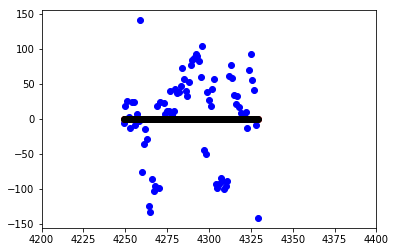

In [20]:
plt.scatter(df["framenum"],df["phase_med_highFreqPerfect_L"], color='b')
plt.scatter(df["framenum"],df["phase_med_lowFreqPerfect"], color='r')
plt.scatter(df["framenum"],df["phase_med_rect"], color='k')
plt.xlim([4200,4400])
plt.show()

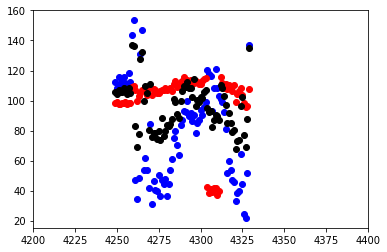

In [19]:
plt.scatter(df["framenum"],df["phase_std_highFreqPerfect_L"], color='b')
plt.scatter(df["framenum"],df["phase_std_lowFreqPerfect"], color='r')
plt.scatter(df["framenum"],df["phase_std_rect"], color='k')
plt.xlim([4200,4400])
plt.show()

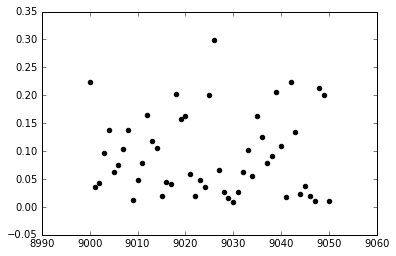

In [32]:
#plt.scatter(df["framenum"],df["phase_normVec_highFreqPerfect_L_x"], color='b')
#plt.scatter(df["framenum"],df["phase_normVec_highFreqPerfect_L_y"], color='r')
plt.scatter(df["framenum"],np.sqrt(np.power(df["phase_normVec_highFreqPerfect_L_x"].values,2.),
                                   np.power(df["phase_normVec_highFreqPerfect_L_y"].values,2.)), color='k')
plt.show()

In [31]:
df["phase_normVec_highFreqPerfect_L_x"].values

array([-0.22388664,  0.03532201,  0.04263646,  0.09670333,  0.13806682,
        0.06264305,  0.07437832,  0.10406917,  0.13770817,  0.0130518 ,
        0.04849938,  0.07805505,  0.16507925, -0.11828314,  0.10587168,
        0.01997622,  0.04414176,  0.04174093,  0.20225613,  0.1573356 ,
        0.16340876, -0.05937441,  0.01921177,  0.04834072,  0.03569861,
        0.20098138,  0.29882959, -0.06531678,  0.02702249, -0.01544348,
       -0.00905657, -0.02664275,  0.06245704,  0.10148444,  0.05575474,
        0.16293086,  0.1253292 ,  0.07855067,  0.09040437,  0.20554595,
        0.10896996,  0.01830214,  0.22330628,  0.13376922, -0.02249788,
        0.03710376,  0.01961676,  0.01056479,  0.21352153,  0.20020515,
       -0.01058913])

In [ ]:
# read in PSF analysis file and make plots

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
psf_analysis = pd.read_csv("psf_analysis_altair_data.csv", na_values="--")

In [36]:
[print(i) for i in psf_analysis.keys()]

framenum
amp_med_highFreqPerfect_L
amp_med_highFreqPerfect_R
amp_med_lowFreqPerfect
amp_med_rect
amp_normVec_highFreqPerfect_L_x
amp_normVec_highFreqPerfect_L_y
amp_normVec_highFreqPerfect_R_x
amp_normVec_highFreqPerfect_R_y
amp_normVec_lowFreqPerfect_x
amp_normVec_lowFreqPerfect_y
amp_normVec_rect_x
amp_normVec_rect_y
arg_med_highFreqPerfect_L
arg_med_highFreqPerfect_R
arg_med_lowFreqPerfect
arg_med_rect
arg_normVec_highFreqPerfect_L_x
arg_normVec_highFreqPerfect_L_y
arg_normVec_highFreqPerfect_R_x
arg_normVec_highFreqPerfect_R_y
arg_normVec_lowFreqPerfect_x
arg_normVec_lowFreqPerfect_y
arg_normVec_rect_x
arg_normVec_rect_y


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

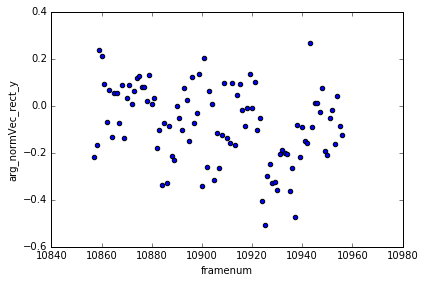

In [46]:
x_axis = "framenum"
y_axis = "arg_normVec_rect_y"
plt.scatter(psf_analysis[x_axis][6500:6600],psf_analysis[y_axis][6500:6600])
plt.xlabel(x_axis)
plt.ylabel(y_axis)
#plt.ylim([-0.00005,0.00005])
plt.tight_layout()
plt.savefig(y_axis+"_vs_"+x_axis+"_testDetail.pdf")
#plt.show()

In [ ]:
# how are FFTs affected by
# 1. fringe movement
# 2. changing visibility
# 3. stuff listed in my table

# ... and how good am I at finding the center of the PSF?

In [ ]:
# based on the images, decide whether to move HPC in piston, tip, tilt
# iterate?
# maybe I don't want to move HPC in piston, because I found the center of the envelope with the grism,
# and Phasecam isn't closed yet